# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
!pip install seaborn==0.11.0

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing as pre 
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [3]:
sns.__version__

'0.11.0'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', dtype=str, sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', dtype=str, sep=';') 

In [5]:
# Browsing the data set, I can see there are 85 columns and 891,221 rows of data. 
print(len(azdias))
azdias.head()

891221


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5,1,5,2,5,4,5,...,2,3,2,1,1,5,4,3,5,4
2,-1,3,2,3,1,4,1,2,3,5,...,3,3,1,0,1,4,4,3,5,2
3,2,4,2,2,4,2,5,2,1,2,...,2,2,2,0,1,3,4,2,3,3
4,-1,3,1,5,4,3,4,1,3,2,...,2,4,2,1,2,3,3,4,6,5


In [6]:
# Reviewing the fate_info dataset. 
# This has the column names, information_level, type and missing_or_unknown data indicator
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
# Making a copies of both the data sets
pop_df = azdias.copy()
inf = feat_info.copy()
# Removing the "[]" brackets from the missing data codes since this was read as a string
inf['missing_or_unknown']=inf['missing_or_unknown'].str.replace('[','')
inf['missing_or_unknown']=inf['missing_or_unknown'].str.replace(']','')
# Splitting the missing data codes by ","
inf[['x', 'y','z']] = inf['missing_or_unknown'].str.split(',', 2, expand=True)

In [8]:
# Creating for loop to convert missing value codes to np.nan
for i in range(len(inf)):
    w =inf.loc[i,'attribute']
    x = inf.loc[i,'x']
    y = inf.loc[i,'y']
    z = inf.loc[i,'z']
    pop_df[w].replace(x, np.nan, inplace=True)
    if y != None:
        pop_df[w].replace(y, np.nan, inplace=True)
    if z != None:    
        pop_df[w].replace(z, np.nan, inplace=True) 

In [9]:
# Verifying the data was converted
pop_df.shape

(891221, 85)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null object
ALTERSKATEGORIE_GROB     888340 non-null object
ANREDE_KZ                891221 non-null object
CJT_GESAMTTYP            886367 non-null object
FINANZ_MINIMALIST        891221 non-null object
FINANZ_SPARER            891221 non-null object
FINANZ_VORSORGER         891221 non-null object
FINANZ_ANLEGER           891221 non-null object
FINANZ_UNAUFFAELLIGER    891221 non-null object
FINANZ_HAUSBAUER         891221 non-null object
FINANZTYP                891221 non-null object
GEBURTSJAHR              498903 non-null object
GFK_URLAUBERTYP          886367 non-null object
GREEN_AVANTGARDE         891221 non-null object
HEALTH_TYP               780025 non-null object
LP_LEBENSPHASE_FEIN      793589 non-null object
LP_LEBENSPHASE_GROB      796649 non-null object
LP_FAMILIE_FEIN          813429 non-null object
LP_FAMILIE_GROB          

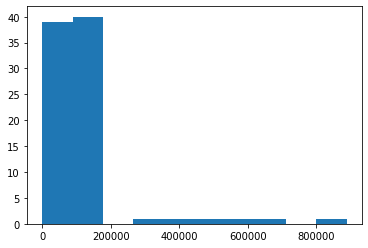

In [11]:
# Investigate patterns in the amount of missing data in each column.
miss = pop_df.isna().sum()
plt.hist(miss);

**It looks like there the outlier columns are missing over 200,000 rows of data**

In [12]:
# Creating a list of the columns missing more than 200,000 rows of data
miss = pd.DataFrame(miss)
miss = miss[(miss > 200000).all(axis=1)]
# Getting the percentage of data missing for each of these rows
miss['percentage'] = miss[0]/891221
miss

,0,percentage
AGER_TYP,685843,0.769554
GEBURTSJAHR,392318,0.440203
TITEL_KZ,889061,0.997576
ALTER_HH,310267,0.348137
KK_KUNDENTYP,584612,0.655967
KBA05_BAUMAX,476524,0.534687


In [13]:
# Reviewing the data in each of these columns
for i in miss.index:
    print(pop_df[i].groupby(pop_df[i]).count())

AGER_TYP
1    79802
2    98472
3    27104
Name: AGER_TYP, dtype: int64
GEBURTSJAHR
1900       4
1902       1
1904       5
1905       8
1906       7
1907       4
1908       7
1909       7
1910      41
1911      30
1912      28
1913      39
1914      55
1915      37
1916      45
1917      55
1918      85
1919     194
1920     238
1921     355
1922     375
1923     468
1924     603
1925     728
1926     865
1927    1021
1928    1180
1929    1275
1930    1625
1931    1535
        ... 
1988    7801
1989    7251
1990    6848
1991    5741
1992    5200
1993    4635
1994    4249
1995    4009
1996    4047
1997    4026
1998     830
1999     744
2000     753
2001     748
2002     782
2003     707
2004     679
2005     592
2006     570
2007     567
2008     550
2009     559
2010     545
2011     485
2012     806
2013     380
2014     124
2015     257
2016     167
2017     593
Name: GEBURTSJAHR, Length: 116, dtype: int64
TITEL_KZ
1    1947
2       3
3      49
4      57
5     104
Name: TITEL_KZ, dtyp

#### Discussion 1.1.2: Assess Missing Data in Each Column

The six main outlier columns in this data set are:
1. AGER_TYP with 685,843 rows missing 
    - When reviewing the Data_Dictionary.md, we can see that AGER_TYP (Best-ager typology) had two seperate classifications for unknown data: -1: unknown and 0: no classification possible. Since 76.9% of the rows fell into one of these two categories, the remaining data does not seem like it would be helpful to keep. 
2. GEBURTSJAHR with	392,318 rows missing
    - When reviewing the Data_Dictionary.md, we can see that GEBURTSJAHR (Year of birth) could possibly be helpful in later analysis. 44% of the rows are missing this data though. There is another column, ALTERSKATEGORIE_GROB, which is the estimated age based on given name analysis, but this may not be as accurate.  
3. TITEL_KZ with 889,061 rows missing
    - When reviewing the Data_Dictionary.md, we can see that TITEL_KZ (Academic title flag) has 99.7% missing data because the majority of the population will not have a title listed: Dr, Prof, ect. This column may be helpful since it can be assumed, the population with missing data does not have a title.
4. ALTER_HH with 310,267 rows missing
    - When reviewing the Data_Dictionary.md, we can see that TITEL_KZ (Birthdate of head of household) is missing 34.8% of the row data. This would make analyzing this column difficult and innaccurate.   
5. KK_KUNDENTYP with 584,612 rows missing
    - When reviewing the Data_Dictionary.md, we can see that KK_KUNDENTYP (Consumer pattern over past 12 months) is missing quite a bit of data at 65.5% missing. There is a data point (3) for new customer so someone being a first time customer does not explain the missing data. 
6. KBA05_BAUMAX with 476,524rows missing
    - When reviewing the Data_Dictionary.md, we can see that KBA05_BAUMAX (Most common building type within the microcell) is missing 53.4% of the column's data. 

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
for i in miss.index:
    pop_df.pop(i)
    feat_info = feat_info[feat_info['attribute']!=i]

In [15]:
# Verifying the columns were removed from the dataset
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null object
ANREDE_KZ                891221 non-null object
CJT_GESAMTTYP            886367 non-null object
FINANZ_MINIMALIST        891221 non-null object
FINANZ_SPARER            891221 non-null object
FINANZ_VORSORGER         891221 non-null object
FINANZ_ANLEGER           891221 non-null object
FINANZ_UNAUFFAELLIGER    891221 non-null object
FINANZ_HAUSBAUER         891221 non-null object
FINANZTYP                891221 non-null object
GFK_URLAUBERTYP          886367 non-null object
GREEN_AVANTGARDE         891221 non-null object
HEALTH_TYP               780025 non-null object
LP_LEBENSPHASE_FEIN      793589 non-null object
LP_LEBENSPHASE_GROB      796649 non-null object
LP_FAMILIE_FEIN          813429 non-null object
LP_FAMILIE_GROB          813429 non-null object
LP_STATUS_FEIN           886367 non-null object
LP_STATUS_GROB           

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?
pop_df['rowcount'] = pop_df.shape[1] - pop_df.count(axis=1)
pop_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,rowcount
0,2,1,2,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1,2,5,1,5,2,5,4,5,1,...,3,2,1,1,5,4,3,5,4,0
2,3,2,3,1,4,1,2,3,5,1,...,3,1,0,1,4,4,3,5,2,0
3,4,2,2,4,2,5,2,1,2,6,...,2,2,0,1,3,4,2,3,3,7
4,3,1,5,4,3,4,1,3,2,5,...,4,2,1,2,3,3,4,6,5,0


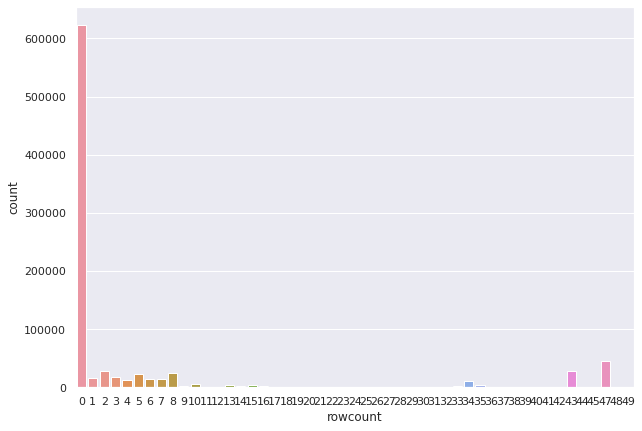

In [17]:
# Creating a countplot to review the rows with the most missing data
sns.set(rc={"figure.figsize":(10, 7)})
sns.countplot(x=pop_df["rowcount"]);

**Splitting the data by rows that have 30 or more columns with missing data and rows with less than 30 columns with missing data**

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# # Creating dataset with rows that have 30 or more columns with missing data
pop_df1 = pop_df[pop_df['rowcount'] >= 30]
print(len(pop_df1))

93160


In [19]:
# Creating dataset with rows that have less than 30 columns with missing data
pop_df2 = pop_df[pop_df['rowcount'] < 30]
print(len(pop_df2))

798061


In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare(column):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.countplot(data=pop_df1, x=column, ax=axes[0]).set_title('Rows with 30 or more NaN')
    sns.countplot(data=pop_df2, x=column, ax=axes[1]).set_title('Rows with less than 30 NaN');

**The columns I choose to compare are:**
1. ANREDE_KZ:
   Gender
     - -1: unknown (missing)
     -  0: unknown (cannot be determined)
     -  1: male
     -  2: female
     
     
2. GREEN_AVANTGARDE
    Membership in environmental sustainability as part of youth
     - 0: not a member of green avantgarde
     - 1: member of green avantgarde
     
     
3. SEMIO_SOZ **socially-minded**
    Personality typology, for each dimension:
     - -1: unknown
     -  1: highest affinity
     -  2: very high affinity
     -  3: high affinity
     -  4: average affinity
     -  5: low affinity
     -  6: very low affinity
     -  7: lowest affinity
     -  9: unknown


4. ZABEOTYP 
    Energy consumption typology
     - -1: unknown
     -  1: green
     -  2: smart
     -  3: fair supplied
     -  4: price driven
     -  5: seeking orientation
     -  6: indifferent
     -  9: unknown


5. ONLINE_AFFINITAET
    Online affinity
     - 0: none
     - 1: low
     - 2: middle
     - 3: high
     - 4: very high
     - 5: highest

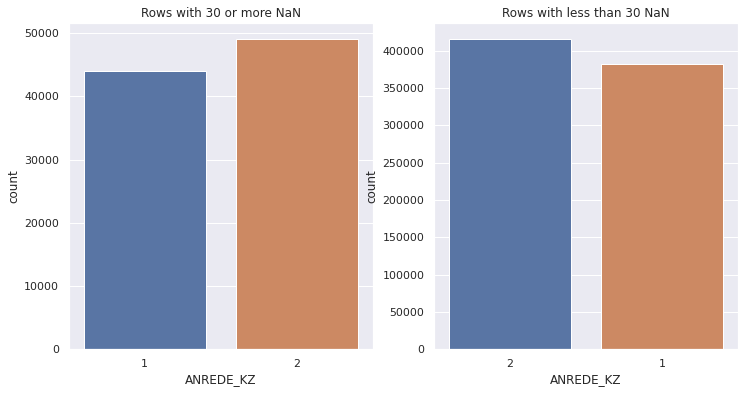

In [21]:
# Using compare function to compare both data sets with 30 or more columns with missing data and less than 30 columns with missing data
compare('ANREDE_KZ')

**This comparison shows both datasets have similar values in this column**

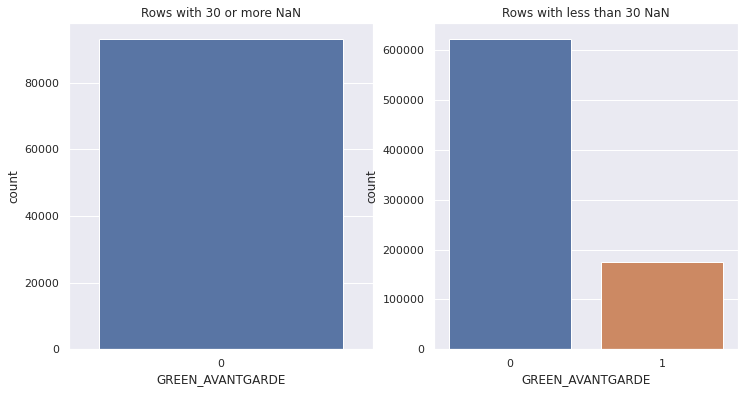

In [22]:
compare('GREEN_AVANTGARDE')

**This comparison shows both datasets have different values in this column with only rows with less than 30 columns missing data having a value of 1**

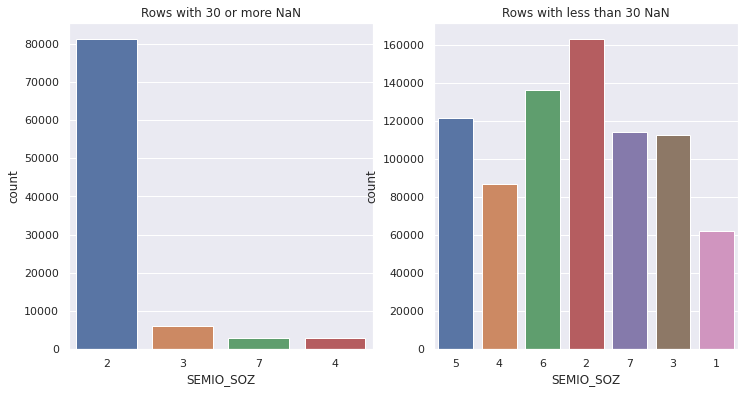

In [23]:
compare('SEMIO_SOZ')

**This comparison shows both datasets have different values in this column. Rows with less than 30 columns missing data have a much larger range of values. Rows with 30 or more columns missing data are mostly a value of 2**

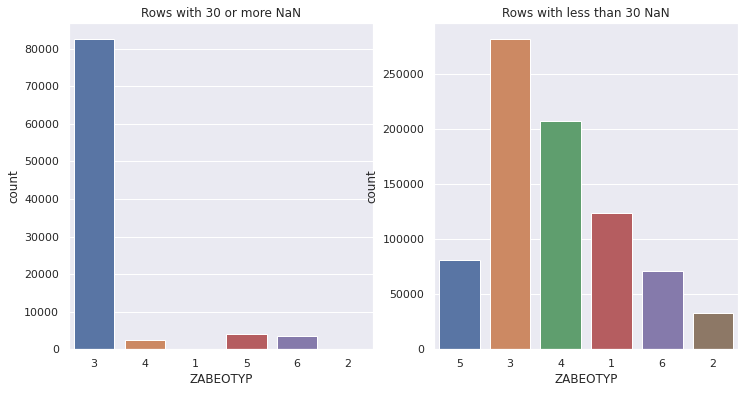

In [24]:
compare('ZABEOTYP')

**This comparison shows both datasets have different values in this column. Rows with 30 or more columns missing data are mostly a value of 3**

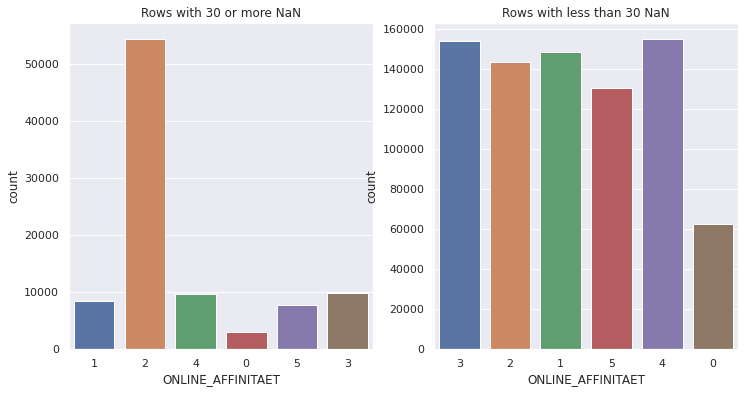

In [25]:
compare('ONLINE_AFFINITAET')

**This comparison shows both datasets have different values in this column. Rows with 30 or more columns missing data are mostly a value of 2**

#### Discussion 1.1.3: Assess Missing Data in Each Row

When assessing the columns, I can see that the comparisons are very different with the exception of column ANREDE_KZ. Most of the rows missing data in 30 or more columns are mainly grouped into one value. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# How many features are there of each data type?
print(feat_info.groupby(['type']).count())

             attribute  information_level  missing_or_unknown
type                                                         
categorical         18                 18                  18
mixed                6                  6                   6
numeric              6                  6                   6
ordinal             49                 49                  49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat = feat_info[feat_info['type']=='categorical'].set_index('attribute')
for i in cat.index:
    print(pop_df[i].groupby(pop_df[i]).count())

ANREDE_KZ
1    425916
2    465305
Name: ANREDE_KZ, dtype: int64
CJT_GESAMTTYP
1     98869
2    148795
3    156449
4    210963
5    117376
6    153915
Name: CJT_GESAMTTYP, dtype: int64
FINANZTYP
1    199572
2    110867
3     53354
4    130625
5    106436
6    290367
Name: FINANZTYP, dtype: int64
GFK_URLAUBERTYP
1      53600
10    109127
11     79740
12    138545
2      46702
3      56007
4      63770
5     120126
6      27138
7      42956
8      88042
9      60614
Name: GFK_URLAUBERTYP, dtype: int64
GREEN_AVANTGARDE
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
LP_FAMILIE_FEIN
1     426379
10    137913
11     51719
2     104305
3       4958
4      12303
5      11920
6       9022
7      20730
8      23032
9      11148
Name: LP_FAMILIE_FEIN, dtype: int64
LP_FAMILIE_GROB
1    426379
2    104305
3     29181
4     52784
5    200780
Name: LP_FAMILIE_GROB, dtype: int64
LP_STATUS_FEIN
1     219275
10    118022
2     118236
3      74105
4      78317
5      74493
6      30914
7    

In [28]:
# Re-encode categorical variable(s) to be kept in the analysis.
cat = cat.drop(['ANREDE_KZ', 'GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP','OST_WEST_KZ'])

In [29]:
pop_df = pd.get_dummies(data=pop_df, columns=['ANREDE_KZ', 'GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP','OST_WEST_KZ'])

In [30]:
for i in cat.index:
    pop_df.pop(i)
    feat_info = feat_info[feat_info['attribute']!=i]    

#### Discussion 1.2.1: Re-Encode Categorical Features

When assessing the categorical columns, I found 5 that could be converted to binary: 'ANREDE_KZ', 'GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP','OST_WEST_KZ'. The remaining 13 columns were dropped from the dataset. I used pd.get_dummies to convert the remaining categorical columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(pop_df["PRAEGENDE_JUGENDJAHRE"].groupby(pop_df["PRAEGENDE_JUGENDJAHRE"]).count())

PRAEGENDE_JUGENDJAHRE
1      21282
10     85808
11     35752
12     24446
13      5764
14    188697
15     42547
2       7479
3      55195
4      20451
5      86416
6      25652
7       4010
8     145988
9      33570
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [32]:
# Mapping decade
pop_df['PRAEGENDE_JUGENDJAHRE_DECADE'] = pop_df['PRAEGENDE_JUGENDJAHRE'].map({'1': '1','2': '1',
                                                                     '3': '2','4': '2',
                                                                     '5': '3','6': '3','7': '3',
                                                                     '8': '4','9': '4',
                                                                     '10': '5','11': '5','12': '5','13': '5',
                                                                     '14': '6','15': '6'})
# Mapping movement
pop_df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = pop_df['PRAEGENDE_JUGENDJAHRE'].map({'1': '1','2': '2','3': '1','4': '2',
                                                                       '5': '1','6': '2','7': '2','8': '1',
                                                                       '9': '2','10': '1','11': '2','12': '1',
                                                                       '13': '2','14': '1','15': '2'})

In [33]:
# Verifying that the values were correctly mapped over to the two new columns
print(pop_df["PRAEGENDE_JUGENDJAHRE_DECADE"].groupby(pop_df["PRAEGENDE_JUGENDJAHRE_DECADE"]).count())
print(pop_df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"].groupby(pop_df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"]).count())

PRAEGENDE_JUGENDJAHRE_DECADE
1     28761
2     75646
3    116078
4    179558
5    151770
6    231244
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64
PRAEGENDE_JUGENDJAHRE_MOVEMENT
1    607832
2    175225
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64


In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(pop_df["CAMEO_INTL_2015"].groupby(pop_df["CAMEO_INTL_2015"]).count())

CAMEO_INTL_2015
12     13249
13     26336
14     62884
15     16974
22     33155
23     26750
24     91158
25     39628
31     19024
32     10354
33      9935
34     18524
35     10356
41     92336
43     56672
44     14820
45     26132
51    133694
52     20542
54     45391
55     23955
Name: CAMEO_INTL_2015, dtype: int64


### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [35]:
# Mapping wealth
pop_df['CAMEO_INTL_2015_WEALTH'] = pop_df['CAMEO_INTL_2015'].map({'12':'1','13':'1','14':'1','15':'1',
                                                          '22':'2','23':'2','24':'2','25':'2',
                                                          '31':'3','32':'3','33':'3','34':'3','35':'3',
                                                          '41':'4','42':'4','43':'4','44':'4','45':'4',
                                                          '51':'5','52':'5','53':'5','54':'5','55':'5'})
# Mapping life stage
pop_df['CAMEO_INTL_2015_LIFE_STAGE'] = pop_df['CAMEO_INTL_2015'].map({'12':'2','13':'3','14':'4','15':'5',
                                                              '22':'2','23':'3','24':'4','25':'5',
                                                              '31':'1','32':'2','33':'3','34':'4','35':'5',
                                                              '41':'1','42':'2','43':'3','44':'4','45':'5',
                                                              '51':'1','52':'2','53':'3','54':'4','55':'5'})

In [36]:
# Verifying the data was mapped correctly to the new columns
print(pop_df["CAMEO_INTL_2015_WEALTH"].groupby(pop_df["CAMEO_INTL_2015_WEALTH"]).count())
print(pop_df["CAMEO_INTL_2015_LIFE_STAGE"].groupby(pop_df["CAMEO_INTL_2015_LIFE_STAGE"]).count())

CAMEO_INTL_2015_WEALTH
1    119443
2    190691
3     68193
4    189960
5    223582
Name: CAMEO_INTL_2015_WEALTH, dtype: int64
CAMEO_INTL_2015_LIFE_STAGE
1    245054
2     77300
3    119693
4    232777
5    117045
Name: CAMEO_INTL_2015_LIFE_STAGE, dtype: int64


In [37]:
# Dropping the remaing mixed columns
mix = feat_info[feat_info['type']=='mixed'].set_index('attribute')
for i in mix.index:
    pop_df.pop(i)
    feat_info = feat_info[feat_info['attribute']!=i]

#### Discussion 1.2.2: Engineer Mixed-Type Features

There were 6 mixed type columns in the dataset. PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were both split into two columns each since they contained coding for two different variables in each column. I then removed the original columns plus the other 4 mixed type columns from the dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Switching all columns to numeric datatypes
pop_df = pop_df.apply(pd.to_numeric)
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 70 columns):
ALTERSKATEGORIE_GROB              888340 non-null float64
FINANZ_MINIMALIST                 891221 non-null int64
FINANZ_SPARER                     891221 non-null int64
FINANZ_VORSORGER                  891221 non-null int64
FINANZ_ANLEGER                    891221 non-null int64
FINANZ_UNAUFFAELLIGER             891221 non-null int64
FINANZ_HAUSBAUER                  891221 non-null int64
HEALTH_TYP                        780025 non-null float64
RETOURTYP_BK_S                    886367 non-null float64
SEMIO_SOZ                         891221 non-null int64
SEMIO_FAM                         891221 non-null int64
SEMIO_REL                         891221 non-null int64
SEMIO_MAT                         891221 non-null int64
SEMIO_VERT                        891221 non-null int64
SEMIO_LUST                        891221 non-null int64
SEMIO_ERL                         891221 no

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(data):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = data.copy()
    # Creating for loop to convert missing value codes to np.nan
    for i in range(len(inf)):
        w = inf.loc[i,'attribute']
        x = inf.loc[i,'x']
        y = inf.loc[i,'y']
        z = inf.loc[i,'z']
        df[w].replace(x, np.nan, inplace=True)
        if y != None:
            df[w].replace(y, np.nan, inplace=True)
        if z != None:    
            df[w].replace(z, np.nan, inplace=True) 
    # Remove the outlier columns from the dataset. (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)
    for i in miss.index:
        df.pop(i)
    # How much data is missing in each row of the dataset?
    df['rowcount'] = df.shape[1] - df.count(axis=1)
    # Creating a countplot to review the rows with the most missing data
    sns.set(rc={"figure.figsize":(10, 7)})
    sns.countplot(x=df["rowcount"]);
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.
    df = pd.get_dummies(data=df, columns=['ANREDE_KZ', 'GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP','OST_WEST_KZ'])
    for i in cat.index:
        df.pop(i)
    # Mapping decade
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map({'1': '1','2': '1',
                                                                     '3': '2','4': '2',
                                                                     '5': '3','6': '3','7': '3',
                                                                     '8': '4','9': '4',
                                                                     '10': '5','11': '5','12': '5','13': '5',
                                                                     '14': '6','15': '6'})
    # Mapping movement
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map({'1': '1','2': '2','3': '1','4': '2',
                                                                       '5': '1','6': '2','7': '2','8': '1',
                                                                       '9': '2','10': '1','11': '2','12': '1',
                                                                       '13': '2','14': '1','15': '2'})
    # Mapping wealth
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].map({'12':'1','13':'1','14':'1','15':'1',
                                                          '22':'2','23':'2','24':'2','25':'2',
                                                          '31':'3','32':'3','33':'3','34':'3','35':'3',
                                                          '41':'4','42':'4','43':'4','44':'4','45':'4',
                                                          '51':'5','52':'5','53':'5','54':'5','55':'5'})
    # Mapping life stage
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].map({'12':'2','13':'3','14':'4','15':'5',
                                                              '22':'2','23':'3','24':'4','25':'5',
                                                              '31':'1','32':'2','33':'3','34':'4','35':'5',
                                                              '41':'1','42':'2','43':'3','44':'4','45':'5',
                                                              '51':'1','52':'2','53':'3','54':'4','55':'5'})
    # Dropping the remaing mixed columns
    for i in mix.index:
        df.pop(i)
    # If there are other re-engineering tasks you need to perform, make sure you
    # take care of them here. (Dealing with missing data will come in step 2.1.)
    # Switching all columns to numeric datatypes
    df = df.apply(pd.to_numeric)
    dfclean = df.copy()
    return dfclean

In [40]:
pop_dfclean = pop_df.copy()

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imp = Imputer(missing_values='NaN', strategy='mean')
imp = imp.fit(pop_dfclean)
pop_dfclean = pd.DataFrame(imp.fit_transform(pop_dfclean), columns = pop_dfclean.columns)

In [42]:
pop_dfclean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ_0,SOHO_KZ_1,VERS_TYP_1,VERS_TYP_2,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,2.190129,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.332805,1.22377,3.262098,2.873033
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.000000,1.0,5.0,...,0.0,1.0,0.0,1.0,0.0,1.0,6.000000,1.00000,5.000000,1.000000
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.000000,3.0,4.0,...,1.0,0.0,1.0,0.0,0.0,1.0,6.000000,2.00000,2.000000,4.000000
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.000000,2.0,5.0,...,1.0,0.0,1.0,0.0,0.0,1.0,4.000000,1.00000,1.000000,2.000000
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.000000,5.0,6.0,...,1.0,0.0,0.0,1.0,0.0,1.0,4.000000,1.00000,4.000000,3.000000


In [43]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
dfscaled = scaler.fit_transform(pop_dfclean)

In [44]:
pop_dfscaler = pd.DataFrame(dfscaled, columns = pop_dfclean.columns)

In [45]:
pop_dfclean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ_0,SOHO_KZ_1,VERS_TYP_1,VERS_TYP_2,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,2.190129,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.332805,1.22377,3.262098,2.873033
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.000000,1.0,5.0,...,0.0,1.0,0.0,1.0,0.0,1.0,6.000000,1.00000,5.000000,1.000000
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.000000,3.0,4.0,...,1.0,0.0,1.0,0.0,0.0,1.0,6.000000,2.00000,2.000000,4.000000
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.000000,2.0,5.0,...,1.0,0.0,1.0,0.0,0.0,1.0,4.000000,1.00000,1.000000,2.000000
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.000000,5.0,6.0,...,1.0,0.0,0.0,1.0,0.0,1.0,4.000000,1.00000,4.000000,3.000000


### Discussion 2.1: Apply Feature Scaling

I used the sklearn Imputer to tranform the missing data to the mean and created a new data frame with these values. Then used sklearn standard scaler to scale this dataset.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [46]:
# Apply PCA to the data.
pca = PCA()
pop_dfpca = pd.DataFrame(pca.fit_transform(pop_dfscaler), columns = pop_dfclean.columns)

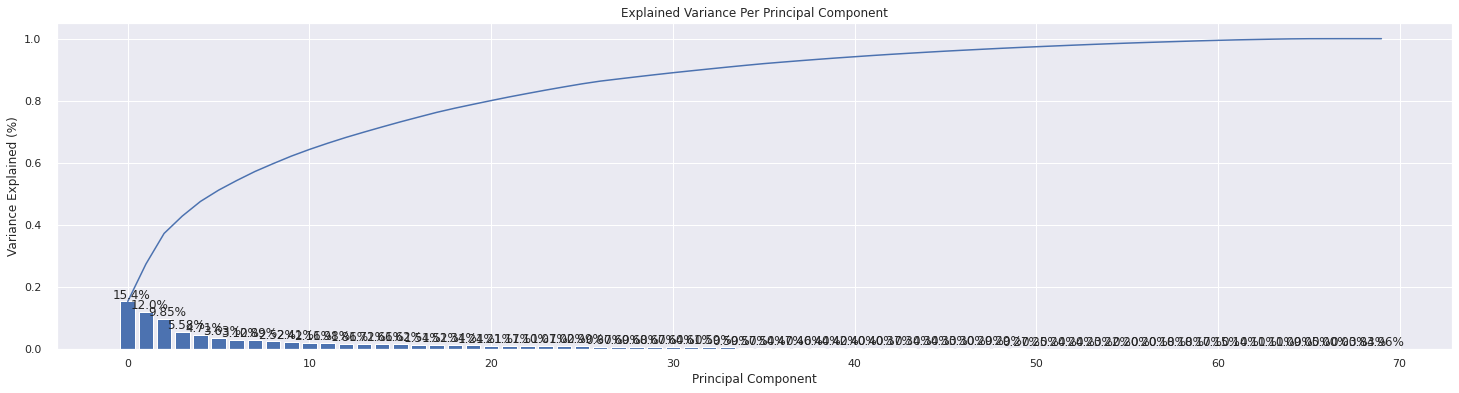

In [47]:
# Investigate the variance accounted for by each principal component.
num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
plt.figure(figsize=(25, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(num_components):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component');

[0.15403495 0.12043577 0.0985026  0.05587495 0.04711896 0.03636568
 0.03109929 0.02896978 0.02525373 0.02416118 0.02160543 0.01983538
 0.01866205 0.01723561 0.01667694 0.01621032 0.01543116 0.01520744
 0.01343518 0.01240446]


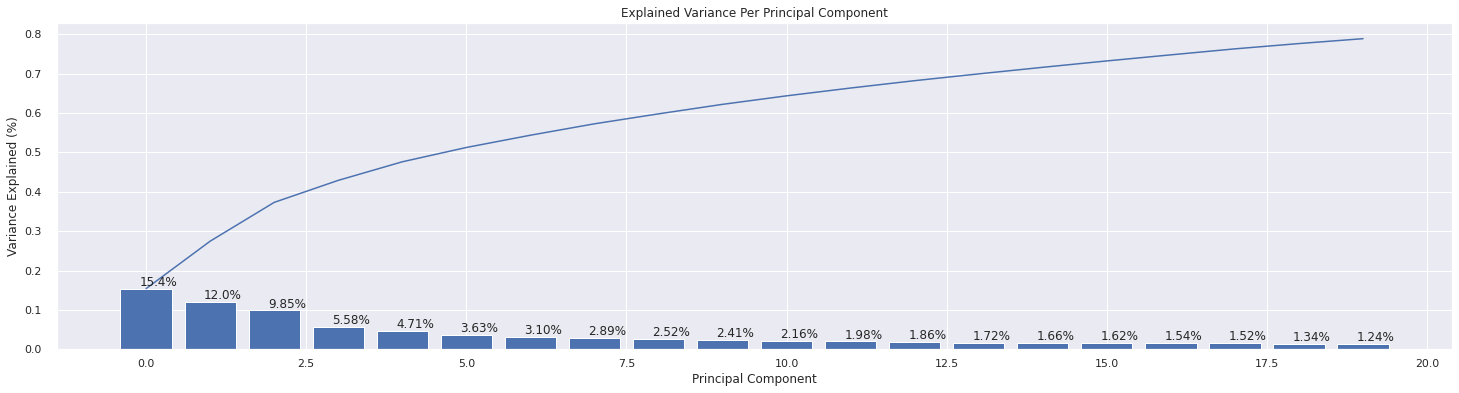

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(20)
pop_dfpca = pd.DataFrame(pca.fit_transform(pop_dfscaler))
print(pca.explained_variance_ratio_)
num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
plt.figure(figsize=(25, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(num_components):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component');

### Discussion 2.2: Perform Dimensionality Reduction

When conducting PCA on all 70 components, it appears that we can get around 80% explained variance with just 20 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [49]:
def pca_features(n, data):
    colnm = pd.DataFrame(list(data))
    comp = pd.DataFrame(pca.components_[n])
    comp['Feature'] = colnm[0]
    comp.rename(columns = {0:'Weight'}, inplace = True)
    comp.set_index('Feature', inplace = True)
    fig, ax = plt.subplots(figsize = (14,8))
    comp.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    comp = comp.sort_values(by=['Weight'], ascending=False)
    return comp

,Weight
Feature,
PLZ8_ANTG3,0.226974
PLZ8_ANTG4,0.220704
CAMEO_INTL_2015_WEALTH,0.209580
ORTSGR_KLS9,0.195269
EWDICHTE,0.193166
HH_EINKOMMEN_SCORE,0.177985
FINANZ_HAUSBAUER,0.165114
KBA05_ANTG4,0.155273
PLZ8_ANTG2,0.152782


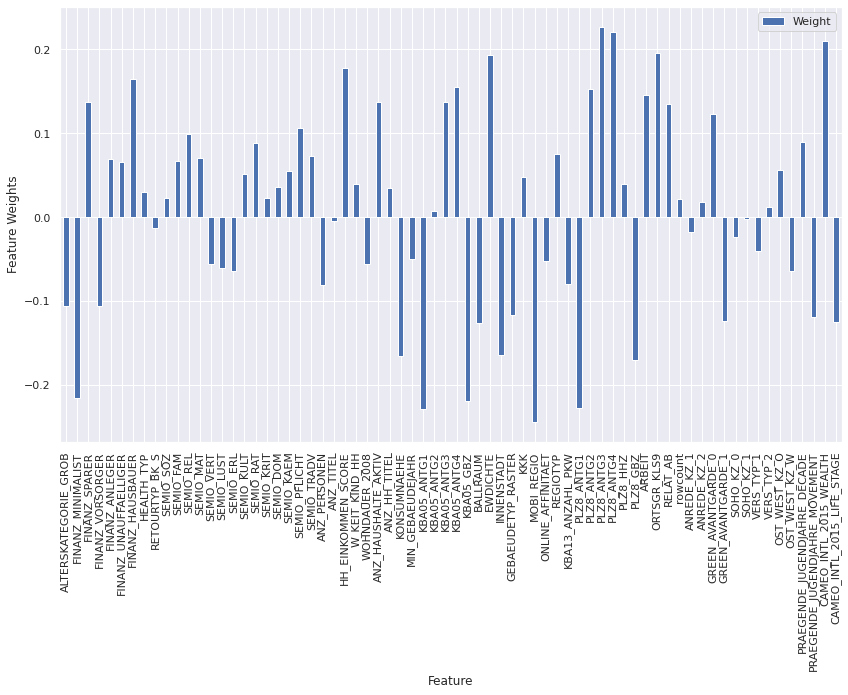

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca_features(0, pop_dfscaler)

,Weight
Feature,
ALTERSKATEGORIE_GROB,0.264215
FINANZ_VORSORGER,0.244558
SEMIO_ERL,0.229776
SEMIO_LUST,0.177269
RETOURTYP_BK_S,0.167194
W_KEIT_KIND_HH,0.121366
FINANZ_HAUSBAUER,0.110755
EWDICHTE,0.085480
PLZ8_ANTG3,0.085125


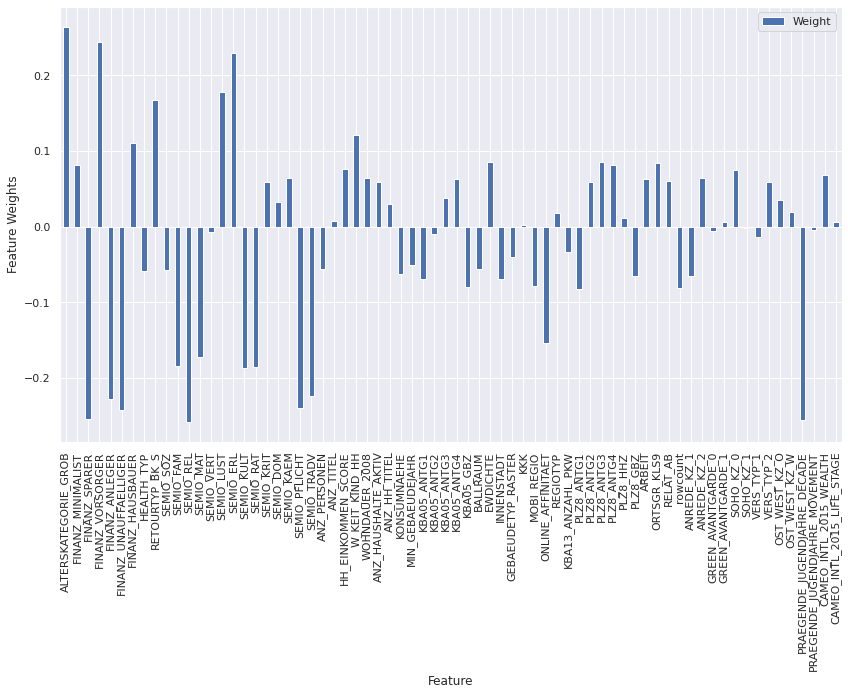

In [51]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_features(1, pop_dfscaler)

,Weight
Feature,
ANREDE_KZ_1,0.332709
SEMIO_VERT,0.331105
SEMIO_SOZ,0.273880
SEMIO_KULT,0.264616
SEMIO_FAM,0.206681
SOHO_KZ_0,0.120441
FINANZ_MINIMALIST,0.107663
RETOURTYP_BK_S,0.070012
GREEN_AVANTGARDE_1,0.059881


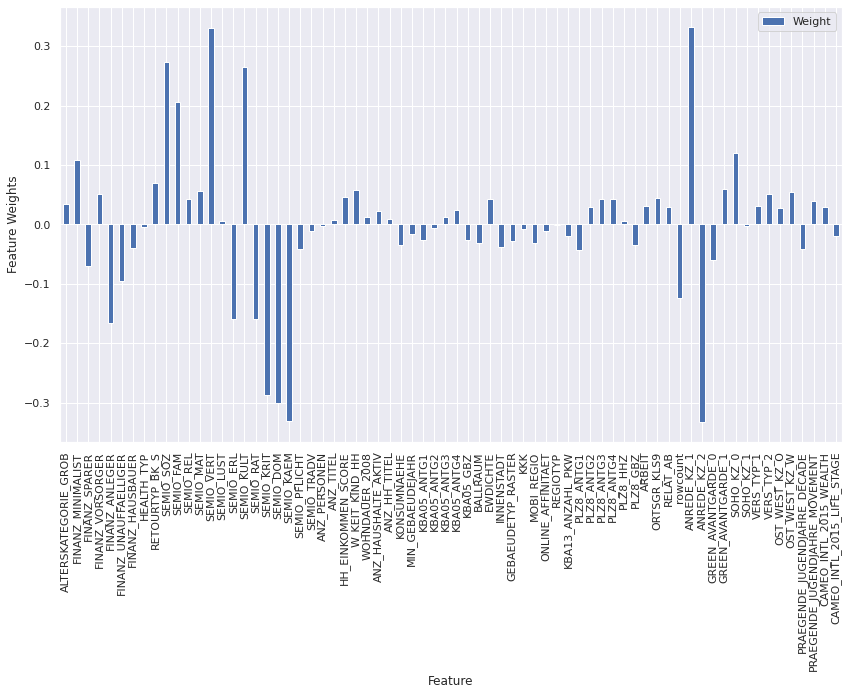

In [52]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_features(2, pop_dfscaler)

### Discussion 2.3: Interpret Principal Components

These 3 components explain 37.25% of the variation in this dataset. We can see the feature weights for each of these components is vastly different. For example, the first component's top feature is PLZ8_ANTG3 with a weight of 22.7%. That same feature has a weght of 8.5% in the second component and 4.2% in the third. 
**The first component's top 5 features:**
1. PLZ8_ANTG3	0.226974
    - Number of 6-10 family houses in the PLZ8 region
2. PLZ8_ANTG4	0.220704
    - Number of 10+ family houses in the PLZ8 region
3. CAMEO_INTL_2015_WEALTH	0.209580
    - This feature describes household wealth   
4. ORTSGR_KLS9	0.195269
    - Size of community
5. EWDICHTE	0.193166
     - Density of households per square kilometer
     
**The second component's top 5 features:**
1. ALTERSKATEGORIE_GROB	0.264215
    - Estimated age based on given name analysis
2. FINANZ_VORSORGER	0.244558
    - Financial typology: be prepared  
3. SEMIO_ERL	0.229776
    - Personality typology: event-oriented
4. SEMIO_LUST	0.177269
    - Personality typology: sensual-minded
5. RETOURTYP_BK_S	0.167194
    - Return type
    
**The third component's top 5 features:**
1. ANREDE_KZ_1	0.332709
    - Gender 
2. SEMIO_VERT	0.331105
    - Personality typology: dreamful 
3. SEMIO_SOZ	0.273880
    - Personality typology: socially-minded
4. SEMIO_KULT	0.264616
    - Personality typology: cultural-minded
5. SEMIO_FAM	0.206681
    - Personality typology: family-minded
    
The first component is heavily based on family size, household wealth and community size and density. The second component is heavily based on age and impulse control. The third component is heavily based on gender and personal values. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [53]:
# Function to find KMeans for multiple numbers of clusters
def kmns(n, data):
    km = MiniBatchKMeans(n)
    model = km.fit(data)
    score = abs(model.score(data))
    return score

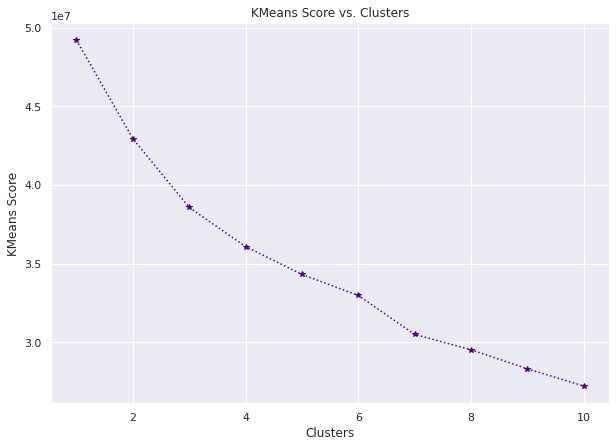

In [54]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
centers = list(range(1,11))
for center in centers:
    scores.append(kmns(center, pop_dfpca)) 
plt.plot(centers, scores, linestyle='dotted', marker='*', color='indigo');
plt.xlabel('Clusters');
plt.ylabel('KMeans Score');
plt.title('KMeans Score vs. Clusters');

In [55]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(7).fit(pop_dfpca)
pop_kmeans = pd.DataFrame(kmeans.fit_predict(pop_dfpca), columns=['predict'])
pop_dfpca['predict'] = pop_kmeans['predict']

In [56]:
pop_dfpca.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,predict
0,0.949004,-2.016640,-2.058277,-0.544348,5.510740,-0.726600,-0.600497,-0.050254,0.145858,-0.302048,...,-0.035348,0.306813,-0.248493,0.281477,-0.015577,0.182848,-0.328917,0.425124,-0.166011,4
1,4.053442,-2.901359,-2.469449,-0.107178,-0.597475,-2.512486,-0.240207,3.293376,-0.661306,0.189402,...,1.796211,2.710132,-2.175499,0.514219,0.163743,-8.864847,7.547915,0.483663,0.560354,3
2,-1.310695,0.212019,-2.644679,3.270599,-1.816022,-0.386741,0.981948,-0.264455,-1.240823,-0.786578,...,1.718102,-0.743581,-0.612876,-0.098805,1.876737,0.335826,-0.256326,2.921411,-0.712553,2
3,-3.904984,1.521313,-1.113079,-1.176750,-0.822569,0.165854,0.828250,-0.501486,0.968785,-0.391061,...,-0.910964,-1.331524,0.240322,-0.014435,-0.855855,-0.039359,0.381937,0.526607,1.593606,1
4,0.469311,0.870448,3.738454,0.298746,-0.539267,0.663950,-3.417427,-1.762547,0.293157,1.443135,...,-1.064489,1.696429,0.824695,-0.668863,1.615746,-0.337059,-0.808922,0.133024,-0.486691,6


### Discussion 3.1: Apply Clustering to General Population

I decided to cluster with 7 centriods since this appears to be the elbow and would get the highest benefit with the least amount of processing time.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [57]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', dtype=str, sep=';')

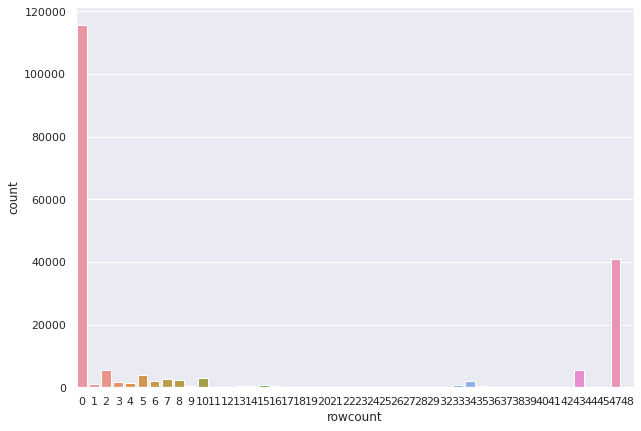

In [58]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cust_dfclean = clean_data(customers)

In [59]:
cust_dfclean.shape

(191652, 70)

In [60]:
cust_dfclean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ_0,SOHO_KZ_1,VERS_TYP_1,VERS_TYP_2,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,4.0,5,1,5,1,2,2,1.0,5.0,6,...,1,0,1,0,0,1,2.0,2.0,1.0,3.0
1,4.0,5,1,5,1,3,2,1.0,NaN,3,...,1,0,1,0,0,0,NaN,NaN,NaN,NaN
2,4.0,5,1,5,1,4,4,2.0,5.0,2,...,1,0,0,1,0,1,2.0,2.0,3.0,4.0
3,4.0,5,1,5,2,1,2,2.0,3.0,6,...,1,0,1,0,0,1,1.0,1.0,2.0,4.0
4,3.0,3,1,4,4,5,2,3.0,5.0,4,...,1,0,0,1,0,1,4.0,1.0,4.0,1.0


In [61]:
cust_dfclean = pd.DataFrame(imp.transform(cust_dfclean), columns = cust_dfclean.columns)
cust_dfscaler = pd.DataFrame(scaler.transform(cust_dfclean), columns = cust_dfclean.columns)
cust_dfpca = pd.DataFrame(pca.transform(cust_dfscaler))

In [62]:
cust_kmeans = pd.DataFrame(kmeans.predict(cust_dfpca), columns=['predict'])
cust_dfpca['predict'] = cust_kmeans['predict']

In [63]:
cust_dfpca.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,predict
0,-6.542642,1.507296,4.053350,2.217543,1.578416,-2.756714,2.955818,-0.016142,-0.812352,-0.395552,...,0.776617,-0.128633,-0.856079,-0.618246,0.353635,1.054627,0.324342,0.032529,-0.382571,2
1,-1.657919,1.139109,2.733841,-1.283775,3.077307,0.249350,1.427249,-0.968364,0.876132,1.427394,...,-0.299727,0.397922,0.253269,-0.288133,0.509415,-0.049996,-0.943676,-0.410740,-0.235099,1
2,-1.596813,5.139887,-1.262607,2.882161,1.168342,0.513316,-1.479026,-0.701587,0.465565,-1.186298,...,1.468478,-0.761095,-0.572048,0.830869,-1.679036,1.523983,0.992246,-0.824630,0.050271,2
3,-4.635282,0.780865,2.619975,-2.941985,0.199325,-1.055966,1.389029,0.236034,1.377105,-0.988335,...,-0.314705,-0.036935,-0.220959,-0.043490,-0.973022,0.666475,0.801856,-0.031587,1.303318,1
4,1.445719,-0.528692,1.925168,-0.711395,-0.769222,-0.639107,-2.176547,-1.146109,0.939655,0.962558,...,-0.581691,2.357033,0.085261,-0.238179,-0.754762,1.971760,1.159020,-0.016415,-1.691741,6


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [64]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
cust_dfpca['index'] = cust_dfpca['predict'].copy()
cust_cluster = cust_dfpca.groupby(['index']).count()
cust_cluster['percentage'] = cust_cluster['predict']/191652
cust_cluster = cust_cluster[['predict','percentage']]
cust_cluster['demographic'] = 'Customer'
cust_cluster

,predict,percentage,demographic
index,,,
0,16907,0.088217,Customer
1,40848,0.213136,Customer
2,64014,0.334012,Customer
3,2736,0.014276,Customer
4,46623,0.243269,Customer
5,4301,0.022442,Customer
6,16223,0.084648,Customer


In [65]:
pop_dfpca['index'] = pop_dfpca['predict'].copy()
pop_cluster = pop_dfpca.groupby(['index']).count()
pop_cluster['percentage'] = pop_cluster['predict']/891221
pop_cluster = pop_cluster[['predict','percentage']]
pop_cluster['demographic'] = 'General Population'
pop_cluster

,predict,percentage,demographic
index,,,
0,126955,0.142451,General Population
1,177488,0.199152,General Population
2,124100,0.139247,General Population
3,148064,0.166136,General Population
4,74509,0.083603,General Population
5,98100,0.110074,General Population
6,142005,0.159338,General Population


In [66]:
combined = cust_cluster.append(pop_cluster)

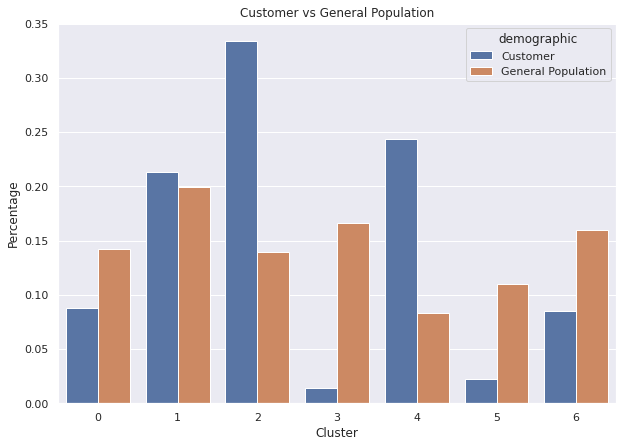

In [67]:
ax = sns.barplot(x= combined.index, y='percentage',hue='demographic', data=combined, errwidth=0)
ax.set(title= "Customer vs General Population", xlabel="Cluster", ylabel='Percentage');

This shows cluster 4 is overrepresented in the cutomer data and cluster 3 is vastly underrepresented.

In [89]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cust_cluster4 = cust_dfpca.loc[cust_dfpca['predict'] == 4]
cust_cluster4.pop('predict')
cust_cluster4.pop('index')
cust_cluster4.shape

(40848, 20)

In [69]:
extracted_4 = scaler.inverse_transform(np.dot(cust_cluster4, pca.components_))
extracted_4 = pd.DataFrame(extracted_4, columns=cust_dfscaler.columns)
extracted_4.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ_0,SOHO_KZ_1,VERS_TYP_1,VERS_TYP_2,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,2.128251,2.821783,4.147241,2.897357,5.245478,5.176888,3.102954,2.106437,3.194295,1.546011,...,0.086561,0.012924,-0.048508,0.040290,0.018699,0.011002,4.391312,1.224823,3.151683,3.038760
1,2.437914,2.894295,4.062627,2.957606,5.165006,5.135770,3.055166,2.056774,3.242282,1.473095,...,0.083764,0.010917,0.009010,-0.022318,0.013090,0.008007,4.303110,1.222988,3.204325,2.941051
2,2.283083,2.858039,4.104934,2.927481,5.205242,5.156329,3.079060,2.081605,3.218288,1.509553,...,0.085162,0.011921,-0.019749,0.008986,0.015895,0.009505,4.347211,1.223906,3.178004,2.989906
3,2.229716,3.084652,4.208682,2.864336,5.120974,5.281051,2.804710,2.247759,3.369512,2.189938,...,0.047336,0.010874,-0.115716,0.073862,-0.000813,-0.017060,4.414700,1.211415,3.182004,2.927973
4,2.539378,3.157165,4.124067,2.924585,5.040502,5.239933,2.756922,2.198096,3.417499,2.117022,...,0.044540,0.008867,-0.058198,0.011253,-0.006422,-0.020054,4.326498,1.209580,3.234647,2.830264


In [74]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cust_cluster3 = cust_dfpca.loc[cust_dfpca['predict'] == 3]
cust_cluster3.pop('predict')
cust_cluster3.pop('index')
cust_cluster3.shape

(2736, 20)

In [75]:
extracted_3 = scaler.inverse_transform(np.dot(cust_cluster3, pca.components_))
extracted_3 = pd.DataFrame(extracted_3, columns=cust_dfscaler.columns)
extracted_3.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ_0,SOHO_KZ_1,VERS_TYP_1,VERS_TYP_2,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,2.237251,3.118806,3.501477,3.049873,3.961571,3.987681,2.717777,1.915215,2.942645,2.985497,...,0.729876,-0.047275,0.419871,0.162143,-0.038823,0.673470,4.697583,1.196292,2.415349,3.649653
1,2.229191,3.703748,2.527237,3.539617,2.920867,3.110096,1.614952,1.943934,3.385106,2.586285,...,0.969665,-0.001884,1.010024,-0.051827,-0.098628,0.989260,4.611533,1.027873,1.931903,3.849625
2,2.162750,2.180371,3.028514,3.057634,2.609445,3.173419,2.727119,2.231347,3.635807,2.639898,...,1.156072,0.033633,0.959176,0.219279,-0.069206,1.210971,5.100065,0.962304,3.276908,2.409200
3,1.138570,3.016832,3.991389,2.351963,4.564955,4.155658,1.612167,2.615154,1.931113,3.056389,...,0.964474,0.006705,-0.138352,1.095374,-0.075286,1.026817,6.121822,1.030886,1.982135,2.964329
4,3.218211,0.896903,4.754177,1.928757,4.628656,4.237911,3.892971,1.587632,1.784362,2.810366,...,1.019838,0.005126,0.922230,-0.004425,0.041020,0.955462,6.143476,1.020847,4.526627,1.912861


### 8.4. PLZ8_ANTG3
Number of 6-10 family houses in the PLZ8 region
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

### 8.5. PLZ8_ANTG4
Number of 10+ family houses in the PLZ8 region
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- 1: Wealthy Households - Pre-Family Couples & Singles
- 2: Prosperous Households - Pre-Family Couples & Singles
- 3: Comfortable Households - Pre-Family Couples & Singles
- 4: Less Affluent Households - Pre-Family Couples & Singles
- 5: Poorer Households - Pre-Family Couples & Singles

### 1.2. ALTERSKATEGORIE_GROB
Estimated age based on given name analysis
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed

### 1.5. FINANZ_VORSORGER: be prepared
Financial typology, for each dimension:
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

### 1.20. SEMIO_ERL: event-oriented
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

### 1.3. ANREDE_KZ_1
Gender
-  0: female
-  1: male

### 1.20. SEMIO_VERT: dreamful
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

### 1.20. SEMIO_SOZ: socially-minded
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown


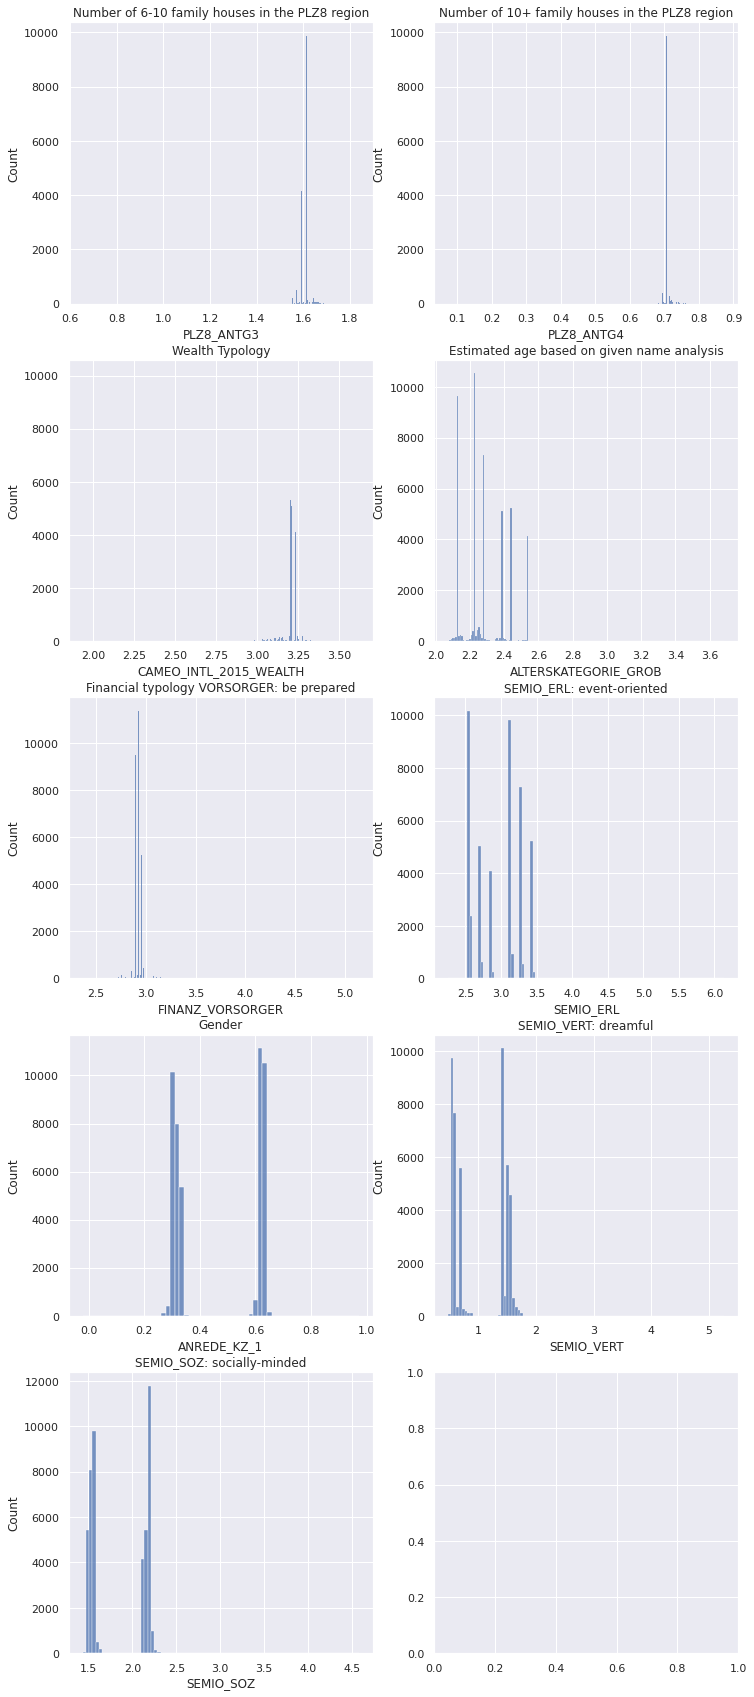

In [105]:
fig, axes = plt.subplots(5, 2, figsize=(12, 30))
sns.histplot(data=extracted_4, x='PLZ8_ANTG3', ax=axes[0,0]).set_title('Number of 6-10 family houses in the PLZ8 region')
sns.histplot(data=extracted_4, x='PLZ8_ANTG4', ax=axes[0,1]).set_title('Number of 10+ family houses in the PLZ8 region')
sns.histplot(data=extracted_4, x='CAMEO_INTL_2015_WEALTH', ax=axes[1,0]).set_title('Wealth Typology')
sns.histplot(data=extracted_4, x='ALTERSKATEGORIE_GROB', ax=axes[1,1]).set_title('Estimated age based on given name analysis')
sns.histplot(data=extracted_4, x='FINANZ_VORSORGER', ax=axes[2,0]).set_title('Financial typology VORSORGER: be prepared')
sns.histplot(data=extracted_4, x='SEMIO_ERL', ax=axes[2,1]).set_title('SEMIO_ERL: event-oriented')
sns.histplot(data=extracted_4, x='ANREDE_KZ_1', ax=axes[3,0]).set_title('Gender')
sns.histplot(data=extracted_4, x='SEMIO_VERT', ax=axes[3,1]).set_title('SEMIO_VERT: dreamful')
sns.histplot(data=extracted_4, x='SEMIO_SOZ', ax=axes[4,0]).set_title('SEMIO_SOZ: socially-minded');

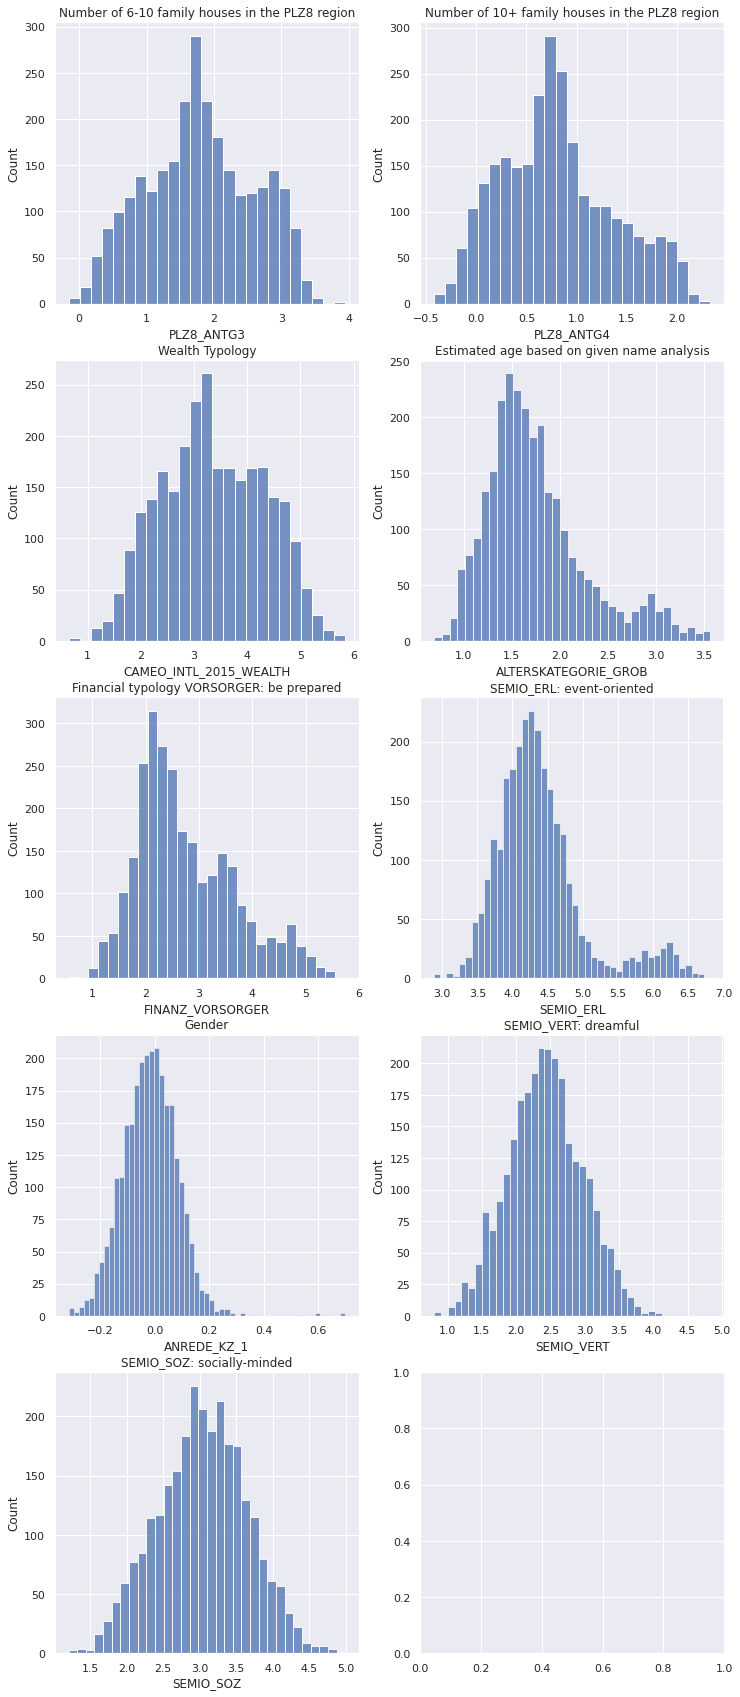

In [106]:
fig, axes = plt.subplots(5, 2, figsize=(12, 30))
sns.histplot(data=extracted_3, x='PLZ8_ANTG3', ax=axes[0,0]).set_title('Number of 6-10 family houses in the PLZ8 region')
sns.histplot(data=extracted_3, x='PLZ8_ANTG4', ax=axes[0,1]).set_title('Number of 10+ family houses in the PLZ8 region')
sns.histplot(data=extracted_3, x='CAMEO_INTL_2015_WEALTH', ax=axes[1,0]).set_title('Wealth Typology')
sns.histplot(data=extracted_3, x='ALTERSKATEGORIE_GROB', ax=axes[1,1]).set_title('Estimated age based on given name analysis')
sns.histplot(data=extracted_3, x='FINANZ_VORSORGER', ax=axes[2,0]).set_title('Financial typology VORSORGER: be prepared')
sns.histplot(data=extracted_3, x='SEMIO_ERL', ax=axes[2,1]).set_title('SEMIO_ERL: event-oriented')
sns.histplot(data=extracted_3, x='ANREDE_KZ_1', ax=axes[3,0]).set_title('Gender')
sns.histplot(data=extracted_3, x='SEMIO_VERT', ax=axes[3,1]).set_title('SEMIO_VERT: dreamful')
sns.histplot(data=extracted_3, x='SEMIO_SOZ', ax=axes[4,0]).set_title('SEMIO_SOZ: socially-minded');

### Discussion 3.3: Compare Customer Data to Demographics Data

When analyzing the overrepresented cluster 4, I can see most of these household are less than 6+ family houses. They are mainly comfortable households in wealth and average age is between 30 and 45. They are average in financial preparedness, have a high affinity for events, and are split between men and women. They have very high affinity for dreaming, which could mean that they like to aspire for better things and they are very highly socially minded. 


When analyzing the underrepresented cluster 3, I can see most of these household are less than 6+ family houses. They are mainly comfortable households in wealth and average age is between 30 and 45. They are higher is preparedness and have less affinity for events. These customers are mainly female and have a high affinity for dreaming. They also seem more socially minded than cluster 4. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.